In [1]:
%matplotlib inline

In [2]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

This time series prediction tutorial uses the Mauna Loa CO2 timeseries. The content is largely based on the tutorial provided by Thomas Vincent (Source: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3; Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License)

In [3]:
co2_data = sm.datasets.co2.load_pandas().data
co2_data.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


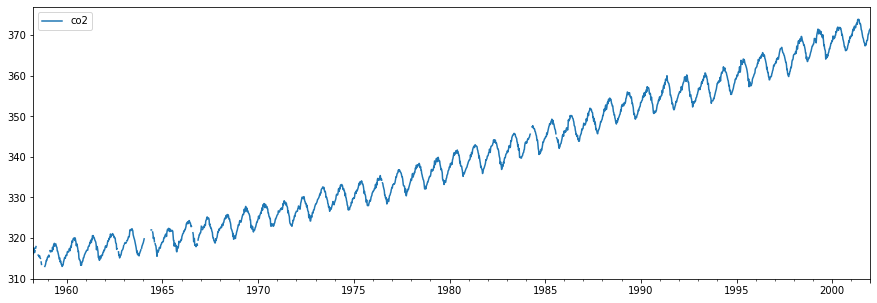

In [4]:
co2_data.plot(figsize=(15, 5));

In [5]:
# The 'MS' string groups the data in buckets by start of the month
co2_data = co2_data.resample('MS').mean()

# The term bfill means that we use the value before filling in missing values
co2_data = co2_data.fillna(co2_data.bfill())

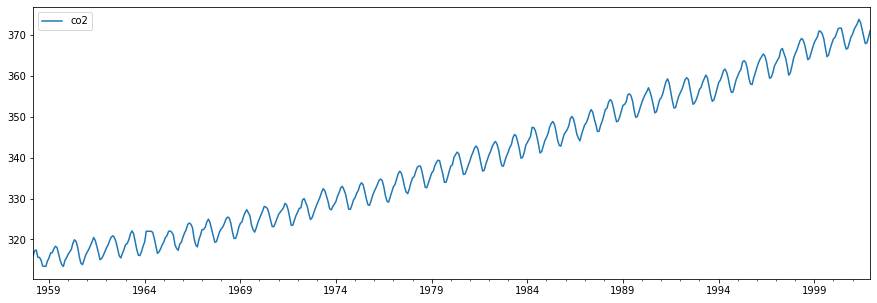

In [6]:
co2_data.plot(figsize=(15, 5));
# now na values are filled

co2_train = co2_data[:"1995-12-31"]
co2_test= co2_data["1996-01-01":]

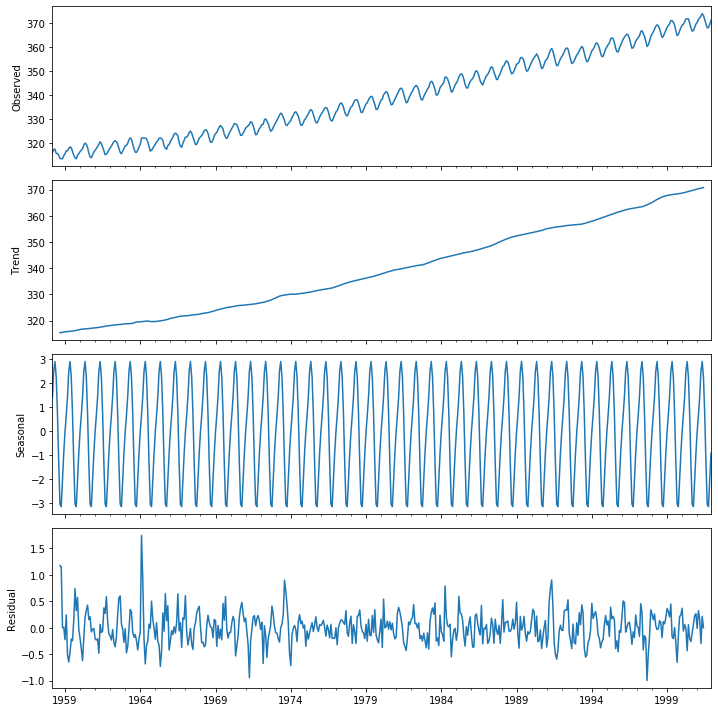

In [7]:
result_add = seasonal_decompose(co2_data, model='additive', freq=12)
# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot();

## Determining the model parameters

Plot the acf and pacf of the residuals:
Which model parameters (p, q) would you use as a first guess?

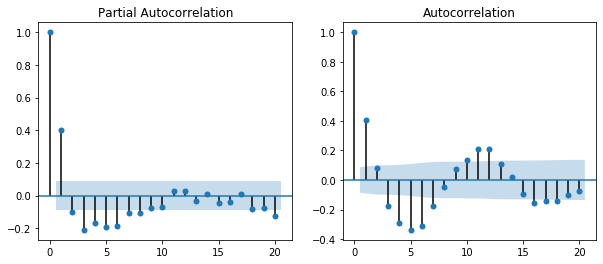

In [8]:
fig,axes = plt.subplots(1, 2, figsize = (10,4))
plot_pacf(result_add.resid.dropna(), lags = 20, ax = axes[0]);
plot_acf(result_add.resid.dropna(), lags = 20, ax = axes[1]);

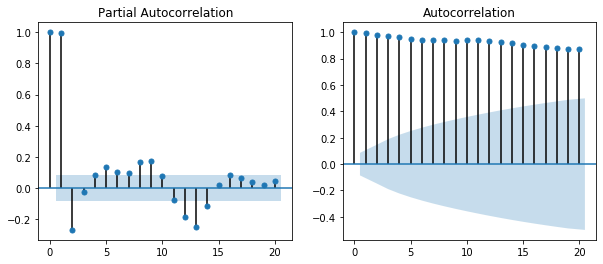

In [9]:
## original timeseries: this acf shows mainly that your data are not yet stationary, 
# (i.e. there is a trend and seasonality) Thus you see a autocorrelation up to very high lags. 
fig,axes = plt.subplots(1, 2, figsize = (10,4))
plot_acf(co2_data.dropna(), lags = 20, ax = axes[1]);
plot_pacf(co2_data.dropna(), lags = 20, ax = axes[0]);

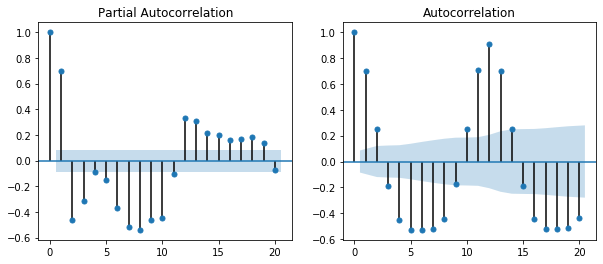

In [10]:
## 1st order Differencing
# here you still see the seasonality component reflected in the differenced time series.
fig,axes = plt.subplots(1, 2, figsize = (10,4))
plot_acf(co2_data.diff().dropna(), lags = 20, ax = axes[1]);
plot_pacf(co2_data.diff().dropna(), lags = 20, ax = axes[0]);

## The ARIMA time series model
One of the most common methods used in time series forecasting is known as the ARIMA model, which stands for AutoregRessive Integrated Moving Average. ARIMA is a model that can be fitted to time series data in order to better understand or predict future points in the series.

There are three distinct integers (p, d, q) that are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation ARIMA(p, d, q). Together these three parameters account for seasonality, trend, and noise in datasets:

p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.

d is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.

q is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.

When dealing with seasonal effects, we make use of the seasonal ARIMA, which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the non-seasonal parameters described above, while (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. The term s is the periodicity of the time series (If we have monthly data this is 4 for quarterly periods, 12 for yearly periods, etc.).

## Automated parameter Selection for the ARIMA Time Series Model
Now we automate the parameter selection. Our selection criterion is that we want to minimize AIC.

In [11]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


We can now use the triplets of parameters defined above to automate the process of training and evaluating ARIMA models on different combinations. In Statistics and Machine Learning, this process is known as grid search (or hyperparameter optimization) for model selection.

When evaluating and comparing statistical models fitted with different parameters, each can be ranked against one another based on how well it fits the data or its ability to accurately predict future data points. We will use the AIC (Akaike Information Criterion) value, which is conveniently returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

The code chunk below iterates through combinations of parameters and uses the SARIMAX function from statsmodels to fit the corresponding Seasonal ARIMA model. Here, the order argument specifies the (p, d, q) parameters, while the seasonal_order argument specifies the (P, D, Q, S) seasonal component of the Seasonal ARIMA model. After fitting each SARIMAX()model, the code prints out its respective AIC score.

In [12]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
AIC_list = pd.DataFrame({}, columns=['pram','param_seasonal','AIC'])

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(co2_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            temp = pd.DataFrame([[ param ,  param_seasonal , results.aic ]], columns=['pram','param_seasonal','AIC'])
            AIC_list = AIC_list.append( temp, ignore_index=True)  # DataFrame append 는 일반 list append 와 다르게 이렇게 지정해주어야한다.
            del temp

        except:
            continue

m = np.amin(AIC_list['AIC'].values) # Find minimum value in AIC
l = AIC_list['AIC'].tolist().index(m) # Find index number for lowest AIC
Min_AIC_list = AIC_list.iloc[l,:]

print("### Min_AIC_list ### \n{}".format(Min_AIC_list))


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:6556.891541172905
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6393.363923372336
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1552.7079655140656
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1321.723860507027
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:875.2029400883137
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:874.7773860049531
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1119.6430423660977
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:866.341349566547
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:5924.993238938077
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:5214.640917502859
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1158.0692666746424
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1033.0589228678855
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:669.3431169191856
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:656.4144124168937
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:932.1576860900734
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:678.9366697162911
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1438.6458610417124
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1059.9131221773325
ARIMA

Because some parameter combinations may lead to numerical misspecifications, we explicitly disabled warning messages in order to avoid an overload of warning messages. These misspecifications can also lead to errors and throw an exception, so we make sure to catch these exceptions and ignore the parameter combinations that cause these issues.

The output of our code suggests that SARIMAX(1, 1, 1)x(1, 1, 1, 12) yields the lowest AIC value. We therefore consider this to be optimal option out of all the models we have considered.

## Fitting an ARIMA Time Series Model
Using grid search, we have identified the set of parameters that produces the best fitting model to our time series data. We can proceed to analyze this particular model in more depth.

We'll start by plugging the optimal parameter values into a new SARIMAX model:

In [13]:
mod = sm.tsa.statespace.SARIMAX(co2_train,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3641      0.091      4.015      0.000       0.186       0.542
ma.L1         -0.6795      0.071     -9.514      0.000      -0.820      -0.540
ar.S.L12       0.0010      0.001      1.702      0.089      -0.000       0.002
ma.S.L12      -0.8699      0.029    -29.690      0.000      -0.927      -0.812
sigma2         0.0986      0.005     21.624      0.000       0.090       0.108


The summary attribute that results from the output of SARIMAX returns a significant amount of information, but we'll first focus our attention on the table of coefficients. The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower or at least close to 0.05, so it is reasonable to retain all of them in our model.



## Model diagnostics
When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.
Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

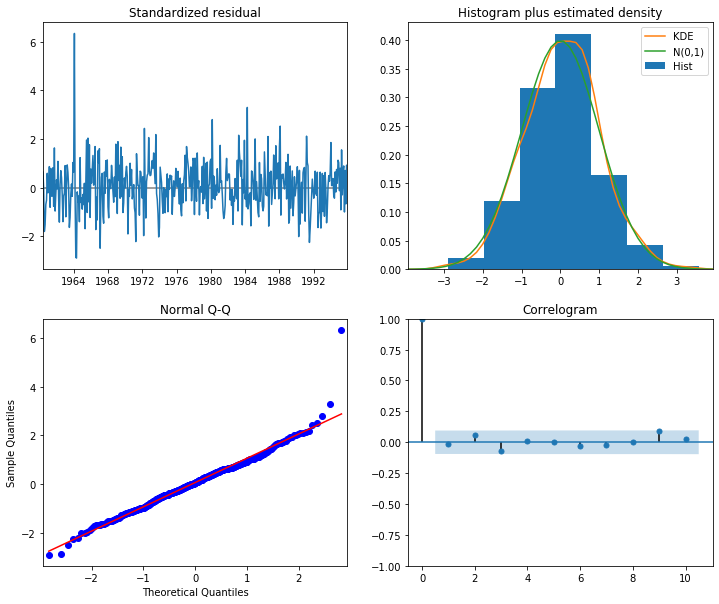

In [14]:
results.plot_diagnostics(figsize=(12, 10));

In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

In the top right plot, we see that the normalized residuals follow closely a standard normal distiribution N(0,1) - a normal distribution with mean 0 and standard deviation of 1. This is a good indication that the residuals are normally distributed.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values.

Although we have a satisfactory fit, some parameters of our seasonal ARIMA model could be changed to improve our model fit. For example, our grid search only considered a restricted set of parameter combinations, so we may find better models if we widened the grid search.

## Validating the forecast
We have obtained a model for our time series that can now be used to produce forecasts. We start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts. The get_prediction() and conf_int() attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series.


In [15]:
pred = results.get_prediction(start=pd.to_datetime('1996-01-01'),end=pd.to_datetime('2002-01-01'),dynamic=True)
pred_ci = pred.conf_int()

In the code chunk below, we specify to start computing the dynamic forecasts and confidence intervals from January 1998 onwards.We can plot the real and forecasted values of the CO2 time series to assess how well we did. Notice how we zoomed in on the end of the time series by slicing the date index. 

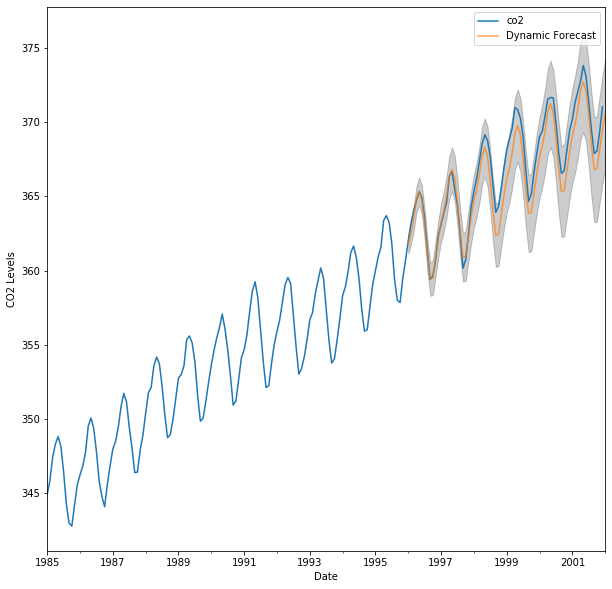

In [16]:
ax = co2_data['1985':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Dynamic Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

Overall, our forecasts align with the true values very well, showing an overall increase trend.

It is also useful to quantify the accuracy of our forecasts. We will use the MSE (Mean Squared Error), which summarizes the average error of our forecasts. For each predicted value, we compute its distance to the true value and square the result. The results need to be squared so that positive/negative differences do not cancel each other out when we compute the overall mean.

In [17]:
co2_forecasted = pred.predicted_mean
co2_truth = co2_data['1996':].co2

# Compute the mean square error
mse = ((co2_forecasted - co2_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.13


The MSE of our prediction is givng the mean difference between predicted and observed data (see formula). An MSE of 0 would that the estimator is predicting observations of the parameter with perfect accuracy, which would be an ideal scenario but it not typically possible.


You could now try a different model and predictive performance of your forecast by computing the MSE.

## Producing and Visualizing Forecasts

In the final step of this tutorial, we describe how to leverage our seasonal ARIMA time series model to forecast future values. The get_forecast() attribute of our time series object can compute forecasted values for a specified number of steps ahead.

In [18]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=400)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

We can use the output of this code to plot the time series and forecasts of its future values.

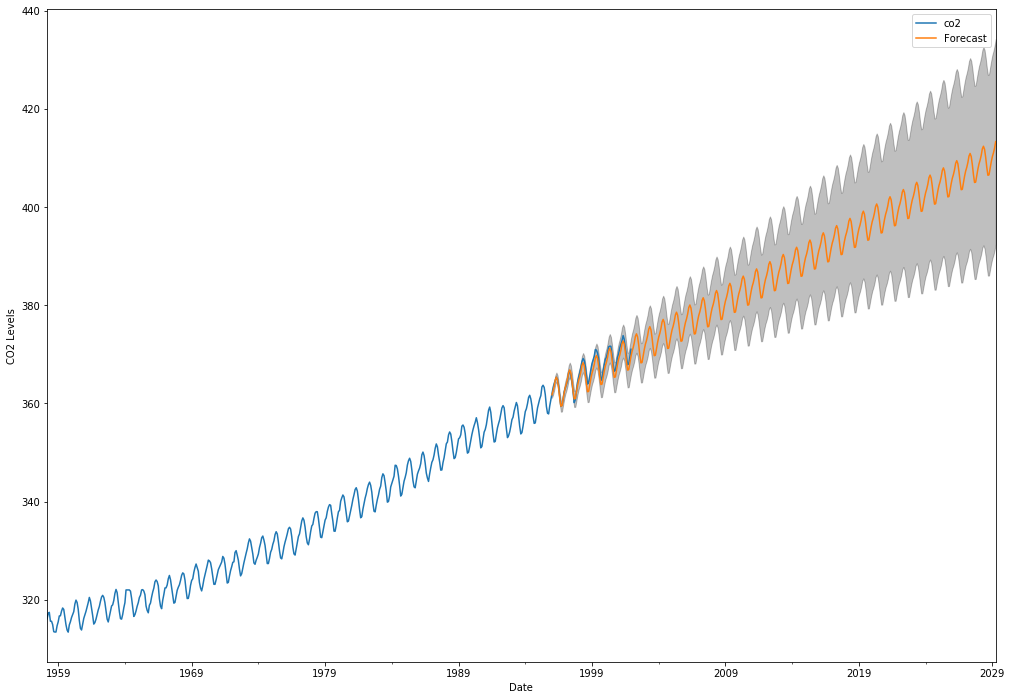

In [19]:
ax = co2_data.plot(label='observed', figsize=(17, 12))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend();

Both the forecasts and associated confidence interval that we have generated can now be used to further understand the time series and foresee what to expect. Our forecasts show that the time series is expected to continue increasing at a steady pace.

As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

The monthly average for May 2019 was at 414.7 parts per million - is this still within the confidence intervals?

## Conclusion

In this tutorial, we described how to implement a seasonal ARIMA model in Python. We made extensive use of the pandas and statsmodels libraries and showed how to run model diagnostics, as well as how to produce forecasts of the CO2 time series.

Here are a few other things you could try:

Change the start date of your dynamic forecasts to see how this affects the overall quality of your forecasts.

Try more combinations of parameters to see if you can improve the goodness-of-fit of your model.

Select a different metric to select the best model. For example, we used the AIC measure to find the best model, but you could seek to optimize the out-of-sample mean square error instead. Make sure you take appropriate validation and test splits, to guarantee you left one part of the data untouchend until the final validation.
i.e. if you optimize the MSE on one period of time, this is period is no longer usable for independent validation and you need to spare an extra period of data.